In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


# Evaluate number of step for QML training
To estimate max number of QML training step in DPO dataset generation.
Train models for various situation, many target functions and many models (number of trainable variable = 1, 2, 3, 4) with some training algorithms, local search and stochastic gradient dicent.

## Settings
|No.|Ng|Algorithm|step|time[sec]|
|---|:-:|:-------:|:--:|:-------:|
|  0| 1| LS| | |
|  0| 2| LS| | |
|  0| 3| LS| | |
|  0| 4| LS| | |
|  0| 1|SGD| | |
|  0| 2|SGD| | |
|  0| 3|SGD| | |
|  0| 4|SGD| | |

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm


In [8]:
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.model.encoding import EncodingUnitManager
from qml.model.unit import UnitManager
from qml.model.model import Model
from qml.optimizer import evaluator as xeval
from qml import optimizer as xoptim


## Protocol

1. Generate random target database
1. Prepare MQC
1. Append random unit avec 3 param
1. train MQL
1. log

## Parameters

In [38]:
# mqp
num_qubits = nq = 2
num_gates = ng = 3

# target dataset
db_size = 10
target_max_order = 5

# optimization
train_step = 10


### 0. generate random target database

In [34]:
def generate_dataset(target_max_order, db_size):
    qml_func = xtarget.PolynominalTargetFunctionGenerator(target_max_order)
    qml_dgen = MLDatasetGenerator(qml_func)
    qml_dataset = qml_dgen.generate(db_size)
    return qml_dataset


### 1. prepare MQC

In [25]:
uman = UnitManager(nq, ng)


In [35]:
def prepare_mqc(nq, ng):
    eunit = EncodingUnitManager.AngleEncoding(1, nq, repeat=True)
    while True:
        tunit = uman.generate_random_unit()
        if tunit.parameters.size == ng:
            break
    model = Model(nq, 1, eunit, [], tunit)
    return model


### 3. append
PASS

### 4. train MQL

In [83]:
Result = namedtuple("Result", ["loss", "tts"])
Result2 = namedtuple("Result2", ["loss", "tts", "log"])

def train_mqc(model, dataset, train_step):
    optimizer = xoptim.LocalSearchOptimizer(dataset)
    result = optimizer.optimize(model, train_step, verbose=False)
    return Result2(float(result.first.energy), int(result.result_energies.best.argmin()), result)


## Build all

In [88]:

def run(nq, ng, db_size, train_step, num_round):
    log = Result2([], [], [])
    for round in tqdm(range(num_round)):
        dataset = generate_dataset(target_max_order, db_size)
        model = prepare_mqc(nq, ng)
        result = train_mqc(model, dataset, train_step)
        log.loss.append(result.loss)
        log.tts.append(result.tts)
        log.log.append(result.log)
    return log


In [94]:
result_ls_3 = run(2, 3, 20, 300, 10)
result_ls_3


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [19:24<00:00, 116.48s/it]


Result2(loss=[1.2114698434726632, 0.012470463891598223, 2.1276937095995763, 0.09202261716606146, 0.01913757381984226, 0.08523218426676754, 1.310892219987605, 0.33670796849742507, 0.02008642217143116, 0.12165762853273232], tts=[60, 113, 257, 209, 164, 177, 205, 131, 44, 227], log=[<qml.tools.logger.Logger object at 0x11d46cbf0>, <qml.tools.logger.Logger object at 0x11d793bc0>, <qml.tools.logger.Logger object at 0x11f19b200>, <qml.tools.logger.Logger object at 0x11f1374d0>, <qml.tools.logger.Logger object at 0x11f5b37a0>, <qml.tools.logger.Logger object at 0x11d3957c0>, <qml.tools.logger.Logger object at 0x11d4bdf10>, <qml.tools.logger.Logger object at 0x11d659370>, <qml.tools.logger.Logger object at 0x11dfdcce0>, <qml.tools.logger.Logger object at 0x11dfdf200>])

(0.0, 300.0)

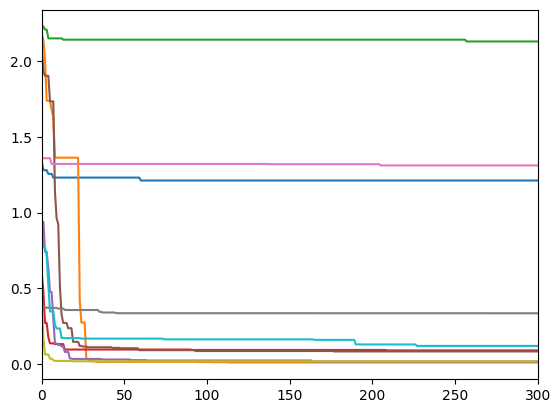

In [99]:
for result in result_ls_3.log:
    result.result_energies.best.plot()
plt.xlim(0, 300)


## Conclusion

num_train_iter = 50